In [1]:
# Importations des bibliothèques necessaires

import pandas as pd # pandas pour charger et explorer les données
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import json
from datetime import datetime




# **Importation des données**

In [2]:
#Charger le fichier d'entraînement
# df_train = pd.read_parquet('/content/drive/My Drive/train-00000-of-00001.parquet')

# Charger le fichier de test
#df_test= pd.read_parquet('/content/drive/My Drive/test-00000-of-00001.parquet')

df_train = pd.read_parquet('train-00000-of-00001.parquet')
df_test = pd.read_parquet('test-00000-of-00001.parquet')

# **Exploration des données**

In [3]:
print(" Train Data:")
print(df_train.head(7))
print(df_train.info())


print("Test Data:")
print(df_test.head(7))
print(df_test.info())

 Train Data:
   label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...
3      3  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...
5      4  Top notch doctor in a top notch practice. Can'...
6      4  Dr. Eric Goldberg is a fantastic doctor who ha...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   650000 non-null  int64 
 1   text    650000 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.9+ MB
None
Test Data:
   label                                               text
0      0  I got 'new' tires from them and within two wee...
1      0  Don't waste your time.  We had two different p...
2  

**Observation** : Les données fournies présentent une structure standard avec deux colonnes, "label" et "text", et une répartition entre un ensemble d'entraînement (650 000 entrées) et un ensemble de test (50 000 entrées).
La colonne "label" est de type "int64", indiquant que les sentiments sont représentés par des nombres entiers.
La colonne "text" est de type "object", ce qui est typique pour stocker des chaînes de caractères dans pandas.

Cependant, les labels (étiquettes) indiquent une classification à 5 (de 0  à 4) classes, et les exemples de texte sont en anglais.

Comme l'ensemble de données d'origine est trop volumineux pour tenir en mémoire de ma machine d'un seul coup, j'ai décidé d'extraire 5 000 entrées en utilisant un échantillonnage stratifié pour s'assurer que la proportion des différentes catégories dans les données d'origine reste la même dans l'échantillon.

In [4]:
# Identifiez la colonne qui représente la catégorie
category_column = 'label'

# Calculer la fraction à échantillonner (5000 / nombre total de lignes)
fraction = 10000 / len(df_test)

# Effectuer un échantillonnage stratifié
df_sample = df_test.groupby(category_column, group_keys=False).apply(lambda x: x.sample(frac=fraction, random_state=42))

df_sample.shape

C:\Users\staures\AppData\Local\Temp\ipykernel_1268\551650605.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_test.groupby(category_column, group_keys=False).apply(lambda x: x.sample(frac=fraction, random_state=42))


(10000, 2)

In [5]:
print("Sample Data:")
print(df_sample.head(7))
print(df_sample.info())

Sample Data:
       label                                               text
31873      0  It was my first day at job. I have to reach at...
23072      0  Never, never again!!  First of all... The only...
7706       0  Used this place before and was satisfied with ...
23399      0  Horrible worst service I've ever had. Slow no ...
22243      0  FIRST -- As I browse the reviews I can't help ...
32246      0  I got acrylics by who I believe to be the owne...
2766       0  R.I.P. Salads N' Such... if you're looking for...
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 31873 to 37846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 234.4+ KB
None


In [6]:
# Obtenez des catégories uniques de la variable cible 'label' et imprimez-les
categories = df_sample['label'].unique()
print(f"Categories in '{'label'}':")
for category in categories:
    print(category)

Categories in 'label':
0
1
2
3
4


In [7]:
# Vérifier la distribution
original_distribution = df_test['label'].value_counts(normalize=True)
sample_distribution = df_sample['label'].value_counts(normalize=True)

print("Original distribution:")
print(original_distribution)
print("\nSample distribution:")
print(sample_distribution)

Original distribution:
label
0    0.2
2    0.2
1    0.2
3    0.2
4    0.2
Name: proportion, dtype: float64

Sample distribution:
label
0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: proportion, dtype: float64


Les résultats de distribution montrent que l'ensemble de données d'origine et l'ensemble de données échantillonné contiennent 5 étiquettes (0 à 4), chacune représentant exactement 20 % des données. Cet équilibre parfait a été maintenu dans le processus d'échantillonnage, démontrant le succès de la technique d'échantillonnage stratifié. L'ensemble de données échantillonné reflète avec précision la distribution des données d'origine, ce qui est idéal pour les tâches d'apprentissage automatique, en particulier les problèmes de classification.

# **Prétraitement des données**

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english')) # utiliser les stop words anglais puisque les exemples de texte sont en anglais
# Download the NLTK vader lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\staures\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\staures\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\staures\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\staures\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
 # Le prétraitement inclut la suppression de la ponctuation, URLs,
 # hashtags, mentions d'utlisateurs et  la conversion en minuscules,
 # la tokenization et la suppression des stop words

 # definir une fonction de prétraitement de texte
def preprocess_text(text):
    # Supprimer les caractères spéciaux
    text = re.sub(r'[^\w\s]', '', text)

    # Supprimer les URLs
    text = re.sub(r'http\S+', '', text)

    # Supprimer les hashtags (mots commençant par #)
    text = re.sub(r'#\w+', '', text)

    # Supprimer les mentions d'utilisateurs (mots commençant par @)
    text = re.sub(r'@\w+', '', text)

    # Convertir en minuscules
    text = text.lower()

    # Tokenization
    # Exemple d'utilisation de la fonction word_tokenize
    # supposons que text = "Check out this awesome #Python tutorial by @katwa! #programming https://www.example.com"
    # tokens va retourner un vecteur de mot individuel ['check', 'out', 'this', 'awesome', 'python', 'tutorial', 'by', 'katwa', 'programming']
    tokens = word_tokenize(text)

    # Supprimer les stop words (mots vides) du texte tokenisé. Exemple des mots vide dans le text ('out', 'this', 'by')
    # qui sont souvent supprimés lors du traitement de texte pour analyser le contenu principal
    tokens = [word for word in tokens if word not in stop_words] # Resultat: ['check', 'awesome', 'python', 'tutorial', 'katwa', 'programming']
    return ' '.join(tokens) # Retourne une chaîne unique en joignant tous les mots traités avec un espace (check awesome python tutorial katwa programming)

In [10]:
# Appliquer la fonction de prétraitement 'preprocess_text' à les colonnes'text' du dataframe 'df_sample' et
# stocker le résultat dans une nouvelle colonne appelée 'processed_text'

df_sample['processed_text'] = df_sample['text'].apply(preprocess_text)


In [11]:
# Créer une copy du dataframe
df = df_sample.copy()

In [12]:
df.head()

,label,text,processed_text
31873,0,It was my first day at job. I have to reach at...,first day job reach office 900 amni called ora...
23072,0,"Never, never again!! First of all... The only...",never never first reason came buffet convienen...
7706,0,Used this place before and was satisfied with ...,used place satisfied service septic wait remov...
23399,0,Horrible worst service I've ever had. Slow no ...,horrible worst service ive ever slow check bac...
22243,0,FIRST -- As I browse the reviews I can't help ...,first browse reviews cant help wonder place do...


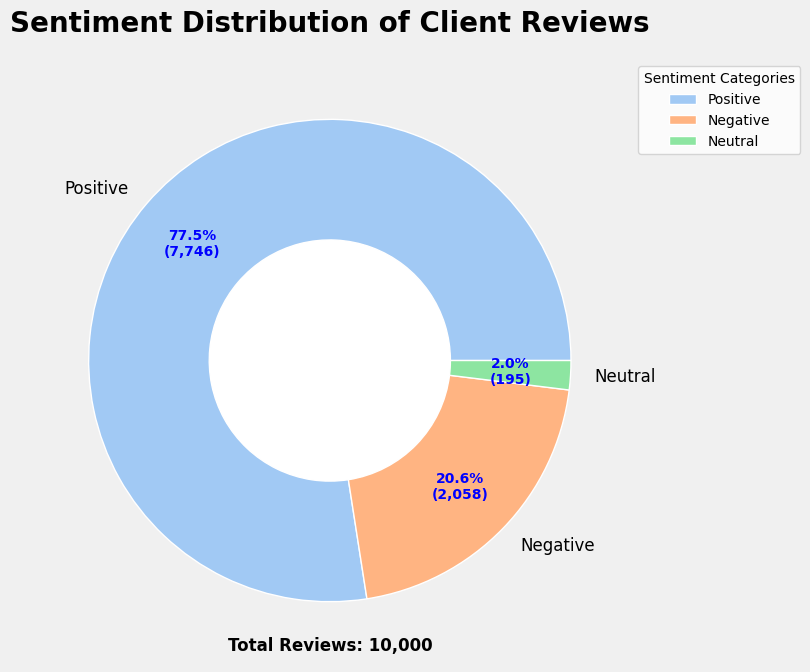

sentiment
Positive    7746
Negative    2059
Neutral      195
Name: count, dtype: int64


In [13]:
# Initialize the NLTK sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Perform sentiment analysis
df['sentiment_scores'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_scores'].apply(get_sentiment)

# Count the sentiments
sentiment_counts = df['sentiment'].value_counts()

# Set up the color palette
colors = sns.color_palette("pastel")[0:3]

# Create the sophisticated pie chart
fig, ax = plt.subplots(figsize=(8, 8), facecolor='#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Create a donut chart
wedges, texts, autotexts = ax.pie(sentiment_counts.values,
                                  labels=sentiment_counts.index,
                                  colors=colors,
                                  autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(sentiment_counts)):,d})',
                                  pctdistance=0.75,
                                  wedgeprops=dict(width=0.5, edgecolor='white'))

# Add a circle at the center to create a donut chart
center_circle = plt.Circle((0,0), 0.50, fc='white')
fig.gca().add_artist(center_circle)

# Customize text properties
plt.setp(autotexts, size=10, weight="bold", color="blue")
plt.setp(texts, size=12)

# Add legend
ax.legend(wedges, sentiment_counts.index,
          title="Sentiment Categories",
          loc="upper left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=10)

# Add a title
plt.title('Sentiment Distribution of Client Reviews', fontsize=20, fontweight='bold', pad=20)

# Add a subtitle
plt.text(0, -1.2, f'Total Reviews: {sum(sentiment_counts):,d}',
         horizontalalignment='center', fontsize=12, fontweight='bold')

# Remove axes
ax.axis('off')

plt.tight_layout()

# Show the plot
plt.show()

# Print the counts
print(sentiment_counts)

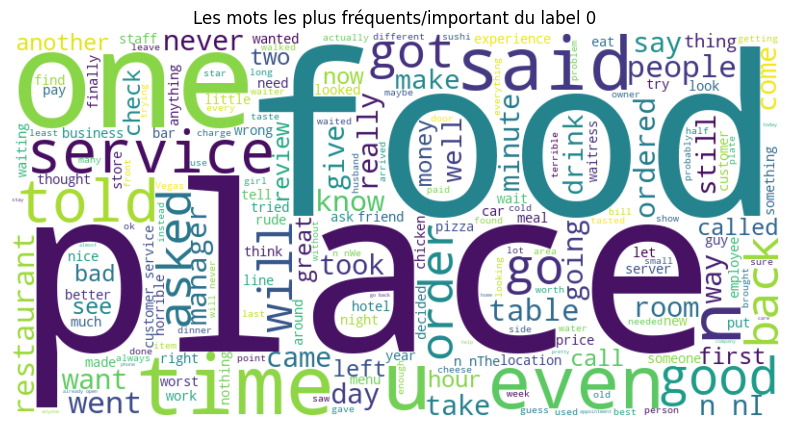

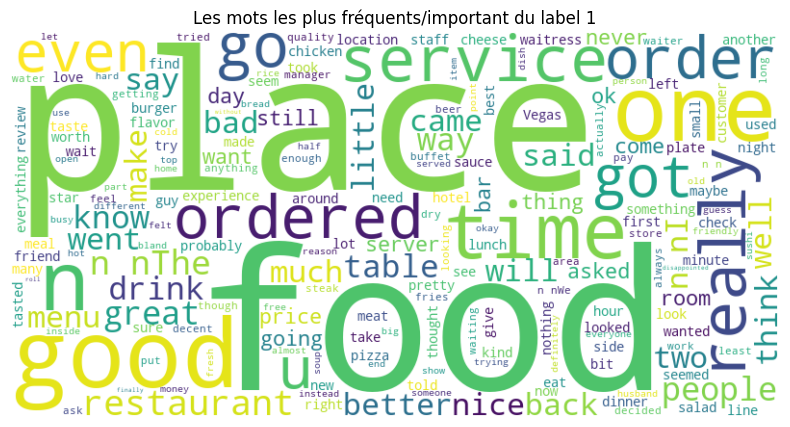

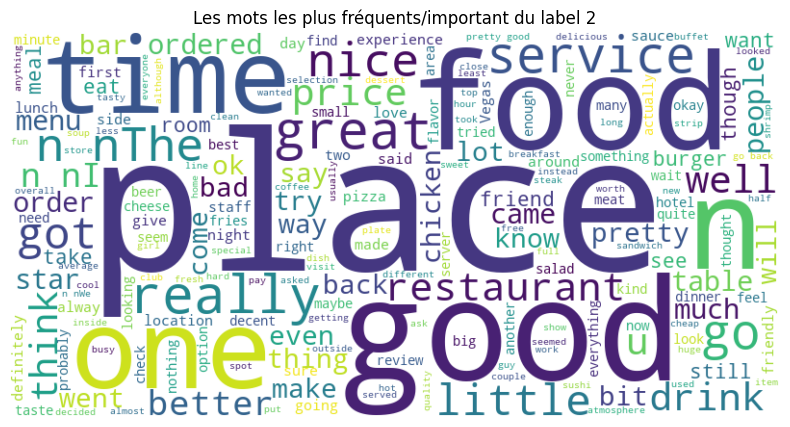

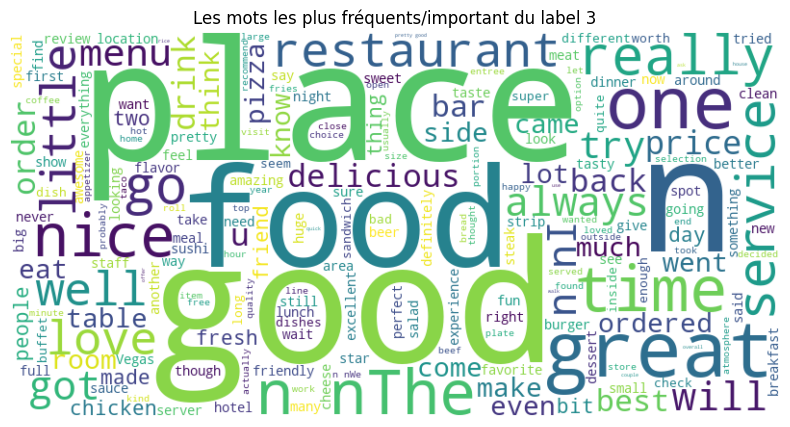

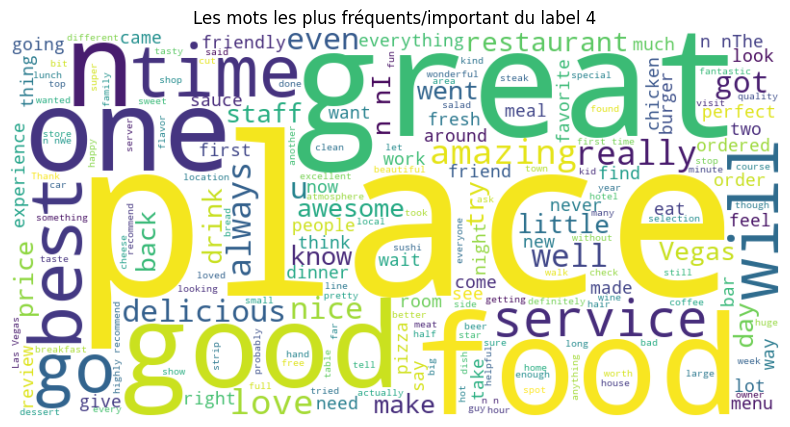

In [14]:
# To create a word cloud for each rating category
for category in df['label'].unique():
    category_text = ' '.join(df[df['label'] == category]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(category_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Les mots les plus fréquents/important du label {category}')
    plt.show()

# **Entraînement & Evaluation des modèles de classification des sentiments**

In [15]:
# Préparation des données pour l'entraînement du modèle

X = df['processed_text']
y = df['label']

>**1. Logistic regression**

In [16]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_log = vectorizer.fit_transform(X)

# Encode labels
le = LabelEncoder()
y_log = le.fit_transform(y)

# Split the data
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In [17]:
# Train the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train_log, y_train_log)


c:\Users\staures\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [18]:
# Make predictions
y_pred_log = model.predict(X_test_log)


In [19]:
# Evaluate the model
accuracy = accuracy_score(y_test_log, y_pred_log)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.5390


In [20]:
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_log, y_pred_log, target_names=le.classes_.astype(str)))


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.70      0.67       410
           1       0.47      0.46      0.47       393
           2       0.48      0.46      0.47       395
           3       0.48      0.43      0.45       415
           4       0.59      0.65      0.62       387

    accuracy                           0.54      2000
   macro avg       0.53      0.54      0.54      2000
weighted avg       0.53      0.54      0.54      2000



>**2. Random Forest**

In [21]:
# Use n-grams in TfidfVectorizer
vectorizerR = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_rf = vectorizerR.fit_transform(X)

In [22]:
# Encode labels
le = LabelEncoder()
y_rf = le.fit_transform(y)

# Split the data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

In [23]:
# An instance of Random Forest
rf_model = RandomForestClassifier(random_state=42)

In [24]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [25]:
# Perform Grid Search
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_rf, y_train_rf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=1)

In [26]:
# Best model
best_rf_model = grid_search.best_estimator_

In [27]:
# Make predictions
y_pred_rf = best_rf_model.predict(X_test_rf)

In [28]:
# Print results
print("Best parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred_rf))

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.76      0.66       410
           1       0.43      0.35      0.39       393
           2       0.41      0.37      0.39       395
           3       0.44      0.31      0.36       415
           4       0.50      0.62      0.55       387

    accuracy                           0.48      2000
   macro avg       0.47      0.48      0.47      2000
weighted avg       0.47      0.48      0.47      2000



**Feature Importance** : Juste pour comprendre quels mots ou n-grammes sont les plus prédictifs. Aussi, Les mots peuvent vous permettre de mieux comprendre ce sur quoi les clients se concentrent dans leurs avis

In [29]:
feature_importance = best_rf_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
top_10_features = feature_names[sorted_idx][-10:]

print("Top 10 important features:")
for feature in reversed(top_10_features):
    print(feature)

Top 10 important features:
granted
genius
bath
al
luckily
crap
oj
levels
window
pricy


>**3. Méthodes d'ensemble :**  étant donné que ni la régression logistique ni la Random Forest n'ont fonctionné exceptionnellement bien, nous allons essayer un ensemble de modèles différents

In [30]:

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un nouveau vectoriseur TF-IDF 
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)

In [31]:
# Créer les pipelines pour chaque modèle de base
lr_pipeline = Pipeline([
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=200, min_samples_leaf=2, min_samples_split=2))
])

svm_pipeline = Pipeline([
    ('svm', SVC(probability=True))
])

In [32]:
# Créer le classificateur d'ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lr', lr_pipeline),
        ('rf', rf_pipeline),
        ('svm', svm_pipeline)
    ],
    voting='soft'
)

In [33]:
# Entraîner le modèle
ensemble.fit(X_train_tfidf, y_train)

c:\Users\staures\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('lr',
                                               LogisticRegression(max_iter=1000,
                                                                  multi_class='multinomial'))])),
                             ('rf',
                              Pipeline(steps=[('rf',
                                               RandomForestClassifier(min_samples_leaf=2,
                                                                      n_estimators=200))])),
                             ('svm',
                              Pipeline(steps=[('svm',
                                               SVC(probability=True))]))],
                 voting='soft')

In [34]:

# Faire des prédictions
X_test_tfidf = tfidf.transform(X_test)
y_pred = ensemble.predict(X_test_tfidf)

In [35]:
# Évaluer le modèle
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       410
           1       0.48      0.46      0.47       393
           2       0.50      0.47      0.48       395
           3       0.48      0.42      0.45       415
           4       0.59      0.64      0.61       387

    accuracy                           0.54      2000
   macro avg       0.54      0.54      0.54      2000
weighted avg       0.54      0.54      0.54      2000



In [36]:
# Obtenir la date et l'heure actuelles
date_trained = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Sauvegarder le modèle et le vectoriseur
joblib.dump(ensemble, 'client_review_classifier.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

# Créer un dictionnaire avec les métadonnées
metadata = {
    'date_trained': date_trained,
    'model_type': 'VotingClassifier',
    'vectorizer': 'TfidfVectorizer',
    'base_models': ['LogisticRegression', 'RandomForestClassifier', 'SVC']
}

# Sauvegarder les métadonnées dans un fichier JSON
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f)

print(f"Modèle et vectoriseur sauvegardés avec succès le {date_trained}.")

Modèle et vectoriseur sauvegardés avec succès le 2024-08-17 00:31:40.
